In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,precision_score,recall_score,f1_score
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.feature_selection import mutual_info_classif
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [2]:
features = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", 
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", 
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", 
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", 
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", 
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate","Label"
]

training_data = pd.read_csv('/Users/younishubsey/desktop/kddcup.data_10_percent.csv',header = None)
# giving the columns the feature names
training_data.columns = features

test_data = pd.read_csv('/Users/younishubsey/desktop/corrected.csv',header = None)
test_data.columns = features

In [3]:
test_data = test_data[test_data["Label"].isin(training_data["Label"].unique())]
print(test_data.shape)

(292300, 42)


In [5]:
attack_categories={
'normal.' : 'Normal',

'back.' : 'DoS', 'land.' : 'DoS', 'neptune.' : 'DoS', 'pod.' : 'DoS', 'smurf.' : 'DoS','teardrop.' : 'DoS',

'buffer_overflow.':'U2R', 'loadmodule.':'U2R', 'perl.':'U2R', 'rootkit.': 'U2R',

'ftp_write.' : 'R2L' , 'guess_passwd.':'R2L', 'imap.':'R2L', 'multihop.':'R2L', 'phf.':'R2L', 'spy.':'R2L', 'warezclient.':'R2L', 'warezmaster.':'R2L',

'ipsweep.':'Probing', 'nmap.':'Probing', 'portsweep.':'Probing', 'satan.': 'Probing'
}

training_data['attack_sections']=training_data['Label'].map(attack_categories)
test_data['attack_sections']=test_data['Label'].map(attack_categories)

In [7]:
# Applying attack category mapping
training_data['attack_sections'] = training_data['Label'].map(attack_categories)
test_data['attack_sections'] = test_data['Label'].map(attack_categories)

# Check if mapping 
print(training_data['attack_sections'].value_counts())

attack_sections
DoS        391458
Normal      97278
Probing      4107
R2L          1126
U2R            52
Name: count, dtype: int64


In [11]:
training_data = training_data[training_data['attack_sections'] != 'U2R']

In [13]:
test_data = test_data[test_data['attack_sections'] != 'U2R']

In [15]:
from sklearn.preprocessing import LabelEncoder
our_categorical_columns = ["Label","attack_sections"]
label_encoder = LabelEncoder()
for col in our_categorical_columns:
    training_data[col]=label_encoder.fit_transform(training_data[col])
    test_data[col] = label_encoder.transform(test_data[col])

In [17]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ["protocol_type","service", "flag"]
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
train_ohe = encoder.fit_transform(training_data[categorical_features])
test_ohe = encoder.transform(test_data[categorical_features])

train_encoded_df = pd.DataFrame(train_ohe, columns=encoder.get_feature_names_out(categorical_features))
test_encoded_df = pd.DataFrame(test_ohe, columns=encoder.get_feature_names_out(categorical_features))

training_data = training_data.drop(columns=categorical_features).reset_index(drop=True)
test_data = test_data.drop(columns=categorical_features).reset_index(drop=True)

training_data = pd.concat([training_data, train_encoded_df], axis=1)
test_data = pd.concat([test_data, test_encoded_df], axis=1)

print("Final Training Shape:", training_data.shape)
print("Final Test Shape:", test_data.shape)

Final Training Shape: (493969, 120)
Final Test Shape: (292261, 120)


In [18]:
x_train =training_data.drop(columns=['Label','attack_sections'])
y_train = training_data['attack_sections']
x_test = test_data.drop(columns=['Label','attack_sections'])
y_test = test_data['attack_sections']

In [19]:
featuress_drop = [
    "num_compromised", "srv_serror_rate", "serror_rate", 
    "dst_host_srv_serror_rate", "srv_rerror_rate", "dst_host_rerror_rate", 
    "dst_host_srv_rerror_rate","num_failed_logins","logged_in","root_shell",
                    "su_attempted","num_file_creations","num_shells",
                    "num_access_files","is_guest_login","num_root","dst_host_same_srv_rate",
    "dst_host_serror_rate", "hot","land","wrong_fragment","urgent","diff_srv_rate","same_srv_rate","srv_diff_host_rate"
    ,"dst_host_srv_diff_host_rate","rerror_rate"#"protocol_type","flag","service" #"protocol_type","flag","service"
]

x_train_select = x_train.drop(columns=featuress_drop)
x_test_select = x_test.drop(columns=featuress_drop)

In [20]:
print(y_train.value_counts())

attack_sections
0    391458
1     97278
2      4107
3      1126
Name: count, dtype: int64


In [23]:
#smote_tomek = SMOTETomek(sampling_strategy = "minority",random_state=42)
#X_resampled, y_resampled = smote_tomek.fit_resample(x_train_select, y_train)

In [26]:
from imblearn.over_sampling import RandomOverSampler

oversampled = RandomOverSampler(sampling_strategy ="minority",random_state=42)
X_resampled, y_resampled = oversampled.fit_resample(x_train_select, y_train)

In [28]:
y_resampled.value_counts()

attack_sections
0    391458
3    391458
1     97278
2      4107
Name: count, dtype: int64


 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    223298
           1       0.99      0.96      0.97     60593
           2       0.90      0.93      0.92      2377
           3       0.79      0.90      0.84      5993

    accuracy                           0.99    292261
   macro avg       0.92      0.95      0.93    292261
weighted avg       0.99      0.99      0.99    292261


 accuracy: 0.9886


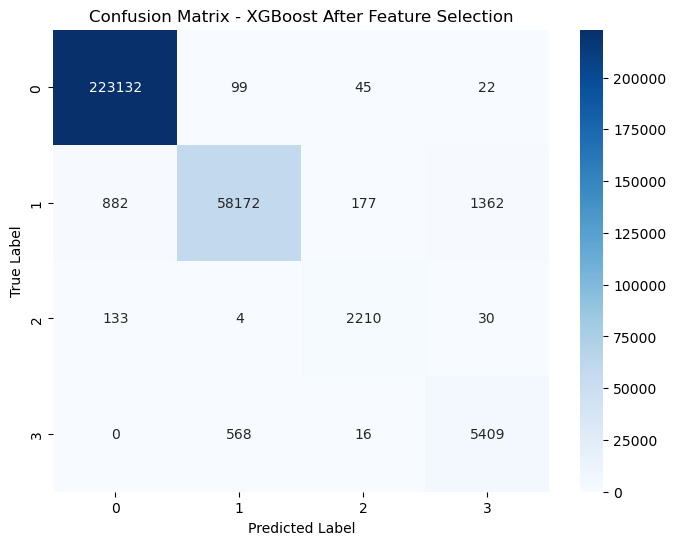

In [30]:
from xgboost import XGBClassifier
import xgboost as xgb
best_params = {
    "max_depth": 1,               # Best tree depth
    "learning_rate": 0.1,         # Best learning rate
    "n_estimators": 230,          # Best number of trees
    "subsample": 0.7,             # Best percentage of training data used per tree
    "colsample_bytree": 0.7,      # Best percentage of features used per tree
    "reg_lambda": 10,
    "reg_alpha": 0.1,
    #"scale_pos_weight": [5]
}

xgb_model = XGBClassifier(
    **best_params,
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42,
)

xgb_model.fit(X_resampled, y_resampled)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = xgb_model.predict(x_test_select)

print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))


accuracy = accuracy_score(y_test, y_pred)
print(f"\n accuracy: {accuracy:.4f}")


import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost After Feature Selection")
plt.show()

 Random Forest Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    223298
           1       0.92      0.95      0.94     60593
           2       0.31      1.00      0.47      2377
           3       0.46      0.36      0.41      5993

    accuracy                           0.96    292261
   macro avg       0.67      0.82      0.70    292261
weighted avg       0.97      0.96      0.96    292261



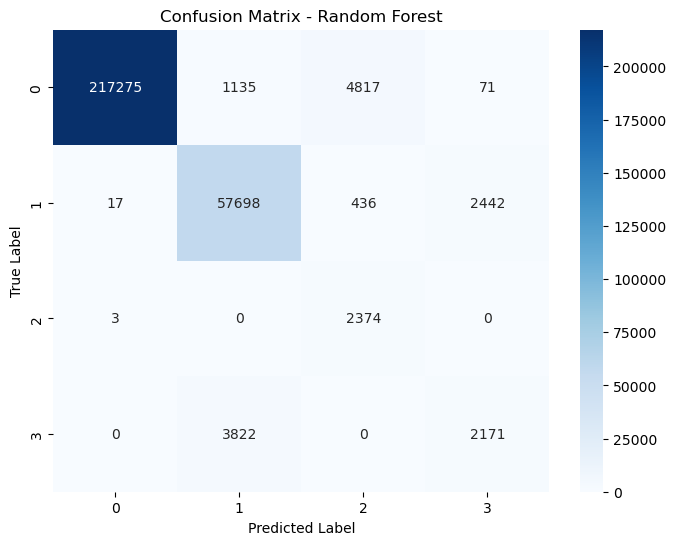

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


random_forest_model = RandomForestClassifier(
    n_estimators=100,  
    max_depth= 3,    #10,     
    class_weight="balanced",  
    random_state=42,
    n_jobs=-1,
    bootstrap = True,
    max_features = 'sqrt',
    min_samples_leaf = 1,
    min_samples_split = 2,
    
)


random_forest_model.fit(X_resampled, y_resampled)


y_pred_rf = random_forest_model.predict(x_test_select)


print(" Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

import seaborn as sns
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [34]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [35]:
rf_param_grid = {
    "n_estimators": [100, 200, 300,500],  # Number of trees
    "max_depth": [1,2,3, 5,8, 10],  # Depth of each tree
    "min_samples_split": [2,3, 5, 10],  # Minimum samples needed to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples in a leaf
    "max_features": ["sqrt", "log2"],  # Number of features per split 
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)



In [ ]:
rf_grid_search = GridSearchCV(
    rf_model, 
    param_grid=rf_param_grid, 
    cv=skf,  
    scoring="recall_macro",  
    verbose=2, 
    n_jobs=-1  
)
rf_grid_search.fit(X_resampled, y_resampled)
print("Best RF Parameters:", rf_grid_search.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


In [ ]:
rf_final = RandomForestClassifier(
    max_depth=10, 
    max_features="log2",
    #class_weight = "balanced",
    min_samples_leaf=15,
    min_samples_split=10,
    n_estimators=250,
    random_state=42,
    n_jobs=-1  
)

In [ ]:
rf_final.fit(X_resampled, y_resampled)

In [ ]:
y_pred = rf_final.predict(x_test_select)


print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))